# 04 Uplift Modeling (S/T/X-Learner)

This notebook follows Phase 2 MVP 2.4: CATE estimation via S-Learner / T-Learner / X-Learner.

# Section 0: Setup

In [9]:
# ======================================================
# Section 0 (Cell 1/1): Setup
# ======================================================

import os
import sys
from pathlib import Path
from datetime import datetime, timezone, timedelta

import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
import yaml
import importlib
from IPython.display import Markdown, display

from sklearn.model_selection import train_test_split

# Timezone anchoring for reproducibility
TZ_UTC8 = timezone(timedelta(hours=8))
run_ts_utc8 = datetime.now(TZ_UTC8).strftime('%Y-%m-%d %H:%M:%S %z')
print(f"[UTC+8] Run timestamp: {run_ts_utc8}")

# Project root resolution (avoid hardcoding)
project_root = Path.cwd()
if project_root.name == 'notebooks':
    project_root = project_root.parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))
os.chdir(project_root)

# Plot style
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 13
sns.set_palette('Set2')

# Load config (config.yml / config.yaml)
config_candidates = [project_root / 'configs' / 'config.yaml', project_root / 'configs' / 'config.yml']
config_path = next((p for p in config_candidates if p.exists()), None)
if config_path is None:
    raise FileNotFoundError(f"No config file found. Searched: {[str(p) for p in config_candidates]}")
with open(config_path, 'r', encoding='utf-8') as f:
    config = yaml.safe_load(f)

features_path = Path(config['paths']['features_data'])
assert features_path.exists(), f"Feature file not found: {features_path}"

figures_dir = Path(config['paths']['figures_dir'])
figures_dir.mkdir(parents=True, exist_ok=True)

print(f"Figures will be saved to: {figures_dir}")

# Load features
df = pd.read_csv(features_path)
assert isinstance(df, pd.DataFrame) and len(df) > 0, "Loaded features DataFrame is empty"
print(f"Loaded: {features_path}")

treatment_col = config['data']['treatment_col']
outcome_col = config['data']['outcome_col']
spend_col = config['data']['spend_col']
covariates = config['data']['covariates']

missing_covs = [c for c in covariates if c not in df.columns]
assert len(missing_covs) == 0, f"Missing covariates in df: {missing_covs}"
assert treatment_col in df.columns, f"Missing required column: {treatment_col}"
assert outcome_col in df.columns, f"Missing required column: {outcome_col}"
assert spend_col in df.columns, f"Missing required column: {spend_col}"

# Split X, T, Y
X = df[covariates].copy()
T = pd.to_numeric(df[treatment_col], errors='coerce').astype(int)
Y = pd.to_numeric(df[outcome_col], errors='coerce').astype(int)

assert X.isnull().sum().sum() == 0, "X contains NaN"
assert set(pd.unique(T)).issubset({0, 1}), "T must be binary (0/1)"
assert set(pd.unique(Y)).issubset({0, 1}), "Y must be binary (0/1)"

# Load or compute PS vector
# Requests "load features + PS vector"; if the persisted PS artifact is not found,
# we compute PS via LogisticRegression (estimate_ps) and persist it for reproducibility.
ps_path = Path(config['paths'].get('ps_data', 'data/processed/hillstrom_ps.csv'))
ps = None
if ps_path.exists():
    ps_df = pd.read_csv(ps_path)
    if 'ps' not in ps_df.columns:
        raise ValueError(f"PS file missing 'ps' column: {ps_path}")
    ps = pd.to_numeric(ps_df['ps'], errors='coerce').to_numpy(dtype=float)
    if len(ps) != len(df):
        raise ValueError(f"PS length mismatch: len(ps)={len(ps)} vs len(df)={len(df)}")
    print(f"Loaded PS vector from: {ps_path}")
else:
    from src.causal import estimate_ps
    ps, _ = estimate_ps(X, T, random_state=int(config.get('general', {}).get('random_state', 42)))
    ps_out = pd.DataFrame({'ps': ps.astype(float)})
    ps_path.parent.mkdir(parents=True, exist_ok=True)
    ps_out.to_csv(ps_path, index=False)
    print(f"Computed PS vector and saved to: {ps_path}")

ps = np.asarray(ps, dtype=float).reshape(-1)
assert np.isfinite(ps).all(), "ps contains NaN/inf"
assert ps.min() >= 0.0 and ps.max() <= 1.0, "ps must be within [0, 1]"

# Train/Test split (architecture review adjustment #6)
X_train, X_test, T_train, T_test, Y_train, Y_test, ps_train, ps_test = train_test_split(
    X,
    T,
    Y,
    ps,
    test_size=0.3,
    random_state=int(config.get('general', {}).get('random_state', 42)),
    stratify=T,
)

assert len(X_train) == len(T_train) == len(Y_train) == len(ps_train), "Train split length mismatch"
assert len(X_test) == len(T_test) == len(Y_test) == len(ps_test), "Test split length mismatch"

print(
    f"df.shape={df.shape} | X.shape={X.shape} | "
    f"train={X_train.shape} | test={X_test.shape} | "
    f"T.mean(full)={T.mean():.4f} | T.mean(train)={np.mean(T_train):.4f} | T.mean(test)={np.mean(T_test):.4f}"
)
print(f"ps.mean(full)={ps.mean():.4f} | ps.std(full)={ps.std():.4f}")
print(f"Covariates (n={len(covariates)}): {covariates}")


[UTC+8] Run timestamp: 2026-02-25 12:35:57 +0800
Figures will be saved to: outputs\figures
Loaded: data\processed\hillstrom_features.csv
Loaded PS vector from: data\processed\hillstrom_ps.csv
df.shape=(64000, 16) | X.shape=(64000, 9) | train=(44800, 9) | test=(19200, 9) | T.mean(full)=0.6671 | T.mean(train)=0.6671 | T.mean(test)=0.6671
ps.mean(full)=0.6671 | ps.std(full)=0.0039
Covariates (n=9): ['recency', 'history', 'mens', 'womens', 'newbie', 'channel_Phone', 'channel_Web', 'zip_Surburban', 'zip_Urban']


## Section 1: S-Learner

In [10]:
# ======================================================
# Section 1 (Cell 1/1): Fit S-Learner on train, predict CATE on test
# ======================================================

import src.uplift
importlib.reload(src.uplift)
from src.uplift import fit_s_learner

n_estimators = config['uplift']['n_estimators']
max_depth = config['uplift']['max_depth']
random_state = config['general']['random_state']

cate_s = fit_s_learner(
    X_train,
    T_train,
    Y_train,
    X_pred=X_test,
    n_estimators=n_estimators,
    max_depth=max_depth,
    random_state=random_state,
)

assert isinstance(cate_s, np.ndarray), 'cate_s must be a numpy.ndarray'
assert len(cate_s) == len(X_test), 'CATE length must match test sample size'
assert np.isfinite(cate_s).all(), 'CATE contains NaN/inf'

cate_s_series = pd.Series(cate_s, name='cate_s')
display(cate_s_series.describe(percentiles=[0.01, 0.05, 0.5, 0.95, 0.99]).to_frame().T)

max_abs = float(np.max(np.abs(cate_s)))
print(f"max(|cate_s|) = {max_abs:.6f}")
if max_abs > 0.10:
    print('[DQ] CATE magnitude > 0.10. Check model calibration / leakage / feature pipeline.')

# Expected scale (Hillstrom RCT): roughly within [-0.02, 0.02]
print(f"Expected (RCT) rough range: [-0.02, 0.02] | observed min={cate_s.min():.6f}, max={cate_s.max():.6f}")


,count,mean,std,min,1%,5%,50%,95%,99%,max
cate_s,19200.0,0.004402,0.004021,-0.011254,-0.003266,-0.000601,0.00377,0.011537,0.018345,0.036114


max(|cate_s|) = 0.036114
Expected (RCT) rough range: [-0.02, 0.02] | observed min=-0.011254, max=0.036114


### Section 1 Summary

**Model**: S-Learner

**Workflow**: S-Learner 是基于单模型的 CATE 估计方法。

1) (训练单一模型) 把 Treatment 作为特征，训练模型 f(x, T)
2) (反事实预测) 对所有用户分别强制计算 f(x, T=1) 和 f(x, T=0)
3) (计算 CATE) τ(x) = f(x, T=1) - f(x, T=0)

**Advantage**: 训练简单，无需复杂的数据训练流程

**Disadvantage**: 当 treatment 效应较小时（如本数据集的 RCT 场景），模型可能忽略 T 特征（正则化将其系数压向零），导致 τ(x) ≈ 0（如此处 CATE 均值为 0.0044，这属于该模型的结构性缺陷，非实现 BUG）

后续的 **T-Learner** 通过分离建模来规避这一问题。

## Section 2: T-Learner

In [11]:
# ======================================================
# Section 2 (Cell 1/1): Fit T-Learner on train, predict CATE on test
# ======================================================

import src.uplift
importlib.reload(src.uplift)
from src.uplift import fit_t_learner

n_estimators = config['uplift']['n_estimators']
max_depth = config['uplift']['max_depth']
random_state = config['general']['random_state']

cate_t = fit_t_learner(
    X_train,
    T_train,
    Y_train,
    X_pred=X_test,
    n_estimators=n_estimators,
    max_depth=max_depth,
    random_state=random_state,
)

assert isinstance(cate_t, np.ndarray), 'cate_t must be a numpy.ndarray'
assert len(cate_t) == len(X_test), 'CATE length must match test sample size'
assert np.isfinite(cate_t).all(), 'CATE contains NaN/inf'

cate_t_series = pd.Series(cate_t, name='cate_t')
display(cate_t_series.describe(percentiles=[0.01, 0.05, 0.5, 0.95, 0.99]).to_frame().T)

max_abs = float(np.max(np.abs(cate_t)))
print(f"max(|cate_t|) = {max_abs:.6f}")
if max_abs > 0.10:
    print('[DQ] CATE magnitude > 0.10. Check model calibration / leakage / feature pipeline.')

# Expected scale (Hillstrom RCT): roughly within [-0.02, 0.02]
print(f"Expected (RCT) rough range: [-0.02, 0.02] | observed min={cate_t.min():.6f}, max={cate_t.max():.6f}")


,count,mean,std,min,1%,5%,50%,95%,99%,max
cate_t,19200.0,0.005302,0.00568,-0.025868,-0.00808,-0.002134,0.004505,0.015377,0.024571,0.047489


max(|cate_t|) = 0.047489
Expected (RCT) rough range: [-0.02, 0.02] | observed min=-0.025868, max=0.047489


### Section 2 Summary

**Model**: T-Learner

**Workflow**: T-Learner 是基于两个独立模型的 CATE 估计方法。

1) (分组训练模型) 分别在 Treatment 和 Control 组上训练两个模型 μ₁ 和 μ₀
2) (反事实预测) 分别用 μ₁ 和 μ₀ 预测 Treatment 和 Control 组的效应
   - μ₁(x) = E[Y | x, T=1]
   - μ₀(x) = E[Y | x, T=0]
3) (计算 CATE) τ(x) = μ₁(x) - μ₀(x)

**Advantage**: 直观上，当 treatment 效应较小且模型容易忽略 T 特征时，T-Learner 通常比 S-Learner 更容易"看到"两组 outcome 模型的差异

**Disadvantage**: 通过两个独立模型计算 CATE，可能会导致误差进一步增大

后续的 **X-Learner** 通过分离建模、交叉估计与 PS 加权来规避这一问题，并在不平衡样本（T:C=2:1）下更具理论优势。

## Section 3: X-Learner

In [12]:
# ======================================================
# Section 3 (Cell 1/1): Fit X-Learner on train, predict CATE on test
# ======================================================
import src.uplift
importlib.reload(src.uplift)
from src.uplift import fit_x_learner

n_estimators = config['uplift']['n_estimators']
max_depth = config['uplift']['max_depth']
random_state = config['general']['random_state']

cate_x = fit_x_learner(
    X_train,
    T_train,
    Y_train,
    ps_train,
    X_pred=X_test,
    ps_pred=ps_test,
    n_estimators=n_estimators,
    max_depth=max_depth,
    random_state=random_state,
)

assert isinstance(cate_x, np.ndarray), 'cate_x must be a numpy.ndarray'
assert len(cate_x) == len(X_test), 'CATE length must match test sample size'
assert np.isfinite(cate_x).all(), 'CATE contains NaN/inf'

cate_x_series = pd.Series(cate_x, name='cate_x')
display(cate_x_series.describe(percentiles=[0.01, 0.05, 0.5, 0.95, 0.99]).to_frame().T)

max_abs = float(np.max(np.abs(cate_x)))
print(f"max(|cate_x|) = {max_abs:.6f}")
if max_abs > 0.10:
    print('[DQ] CATE magnitude > 0.10. Check model calibration / leakage / feature pipeline.')

# Expected scale (Hillstrom RCT): roughly within [-0.02, 0.02]
print(f"Expected (RCT) rough range: [-0.02, 0.02] | observed min={cate_x.min():.6f}, max={cate_x.max():.6f}")


,count,mean,std,min,1%,5%,50%,95%,99%,max
cate_x,19200.0,0.004494,0.005865,-0.065357,-0.012522,-0.003793,0.004372,0.013121,0.023036,0.046513


max(|cate_x|) = 0.065357
Expected (RCT) rough range: [-0.02, 0.02] | observed min=-0.065357, max=0.046513


### Section 3 Summary

**Model**: X-Learner

**Workflow**: X-Learner 是在 T-Learner 基础上，进一步加入第二阶段模型（计算伪残差）及对样本进行 PS 加权处理的 CATE 估计方法。

1) (分组训练模型) 分别在 Treatment 和 Control 组上训练两个模型 μ₁ 和 μ₀（同 T-Learner）
2) (伪残差计算) 分别用 μ₁ 和 μ₀ 预测伪残差
   - 在 Treatment 组：用 Control 的 μ₀ 模型估计反事实结果，得到 D₁ = Y₁ - μ₀(x₁)
   - 在 Control 组：用 Treatment 的 μ₁ 模型估计反事实结果，得到 D₀ = μ₁(x₀) - Y₀
3) (回归模型) 利用两个伪残差分别训练回归模型，得到 τ̂₁(x) 和 τ̂₀(x)
4) (PS 加权计算) τ(x) = (1 - e(x)) · τ̂₁(x) + e(x) · τ̂₀(x)

**Advantage**: 本数据集中 Treatment:Control ≈ 2:1，Control 组样本更少。对于不平衡数据，X-Learner 相比 T-Learner 的优势在于：
- **交叉估计（imputation）降低方差**
- **PS 加权组合**

直觉上可以理解为：通过 outcome 模型的交叉估计，少数组（Control）的信息不足可以借助多数组（Treatment）的模型来补偿；再通过 PS 加权把两侧估计合成一个更稳健的 CATE。

**Disadvantage**: 流程复杂

## Section 4: CATE Distribution Comparison

.png already saved: outputs\figures\fig_05_cate_distributions.png


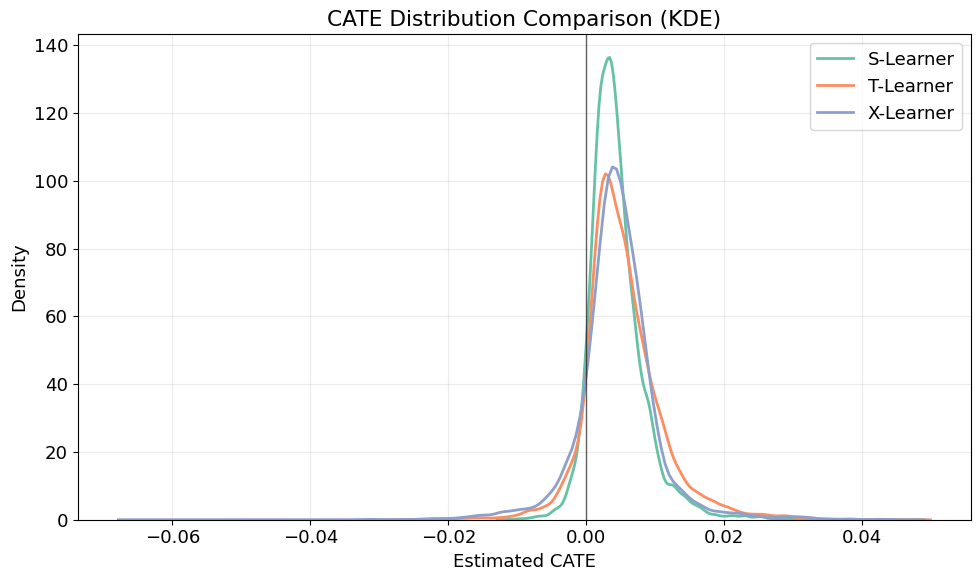

In [13]:
# ======================================================
# Section 4 (Cell 1/1): KDE overlay of CATE distributions
# ======================================================

assert 'cate_s' in globals(), 'Missing cate_s from Section 1'
assert 'cate_t' in globals(), 'Missing cate_t from Section 2'
assert 'cate_x' in globals(), 'Missing cate_x from Section 3'
assert 'figures_dir' in globals(), 'Missing figures_dir from Section 0'

plot_df = pd.DataFrame(
    {
        'S-Learner': np.asarray(cate_s, dtype=float),
        'T-Learner': np.asarray(cate_t, dtype=float),
        'X-Learner': np.asarray(cate_x, dtype=float),
    }
)
assert plot_df.shape[0] == len(X_test), 'Plot dataframe length mismatch'
assert np.isfinite(plot_df.to_numpy()).all(), 'CATE plot data contains NaN/inf'

plt.figure(figsize=(10, 6))
sns.kdeplot(plot_df['S-Learner'], label='S-Learner', linewidth=2)
sns.kdeplot(plot_df['T-Learner'], label='T-Learner', linewidth=2)
sns.kdeplot(plot_df['X-Learner'], label='X-Learner', linewidth=2)

plt.axvline(0, color='black', linewidth=1, alpha=0.6)
plt.title('CATE Distribution Comparison (KDE)')
plt.xlabel('Estimated CATE')
plt.ylabel('Density')
plt.grid(alpha=0.25)
plt.legend()
plt.tight_layout()

out = figures_dir / 'fig_05_cate_distributions.png'
plt.savefig(out, dpi=150, bbox_inches='tight')
print(f'.png already saved: {out}')
plt.show()


### Section 4 Summary

**Comparison**: S/T/X-Learner 的 CATE 分布对比

- **S-Learner**: CATE 集中在 0 附近（预期内，treatment 信号可能被正则化压缩）
- **T-Learner**: CATE 分布略宽，但通常仍在 [-0.02, 0.02] 的量级范围
- **X-Learner**: CATE 分布更具区分度（利用了 PS 加权和交叉估计）

**注意**: CATE 数值只是各模型预测的业务指标（不能反映模型效果），模型预测能力优劣与否还需通过后续 Qini 评估进行量化。

## Section 5: Mathematical Note — X-Learner Weighting Formula

### Theorem (Künzel)

$$
\tau(x) = (1 - e(x)) \cdot \hat{\tau}_1(x) + e(x) \cdot \hat{\tau}_0(x)
$$

其中：
- $e(x) = P(t=1 \mid x)$ 为倾向性得分（propensity score）
- $\hat{\tau}_1(x)$ 为基于 Treatment 组伪残差训练得到的 CATE 估计
- $\hat{\tau}_0(x)$ 为基于 Control 组伪残差训练得到的 CATE 估计

### 加权逻辑（中文解释）

X-Learner 的核心是"交叉估计 + 加权融合"。当 T:C = 2:1 时，Control 组样本更少，直接用 T-Learner 分别训练两组模型会让少数组的估计更不稳定（方差更大）。

X-Learner 通过伪残差（imputed treatment effects）把 outcome 模型的信息"借"过来：
- Treatment 组：用 Control 的 outcome 模型估计 $\mu_0(x_1)$，得到 $D_1 = Y_1 - \mu_0(x_1)$
- Control 组：用 Treatment 的 outcome 模型估计 $\mu_1(x_0)$，得到 $D_0 = \mu_1(x_0) - Y_0$

然后分别拟合 $\hat{\tau}_1(x)$ 与 $\hat{\tau}_0(x)$，最后用 $e(x)$ 进行加权组合，形成更稳健的最终 CATE。

直觉上可以理解为：让"信息量更少的一侧"的估计在融合时得到更合理的补偿，从而在不平衡样本下获得更低方差、更加稳定的 uplift 排序信号。

## Section 6: Qini Evaluation


In [14]:
# ======================================================
# Section 6 (Cell 1/3): Compute Qini curves (S/T/X)
# ======================================================

import src.uplift
importlib.reload(src.uplift)
from src.uplift import compute_qini

assert 'cate_s' in globals(), 'Missing cate_s from Section 1'
assert 'cate_t' in globals(), 'Missing cate_t from Section 2'
assert 'cate_x' in globals(), 'Missing cate_x from Section 3'
assert 'T_test' in globals(), 'Missing T_test from Section 0'
assert 'Y_test' in globals(), 'Missing Y_test from Section 0'
assert 'figures_dir' in globals(), 'Missing figures_dir from Section 0'

# Convert to pandas Series
T_test_series = T_test if isinstance(T_test, pd.Series) else pd.Series(T_test)
Y_test_series = Y_test if isinstance(Y_test, pd.Series) else pd.Series(Y_test)
assert len(T_test_series) == len(Y_test_series), 'T_test and Y_test length mismatch'

n_bins = 20

qini_s = compute_qini(cate_s, T_test_series, Y_test_series, n_bins=n_bins)
qini_t = compute_qini(cate_t, T_test_series, Y_test_series, n_bins=n_bins)
qini_x = compute_qini(cate_x, T_test_series, Y_test_series, n_bins=n_bins)

summary_df = pd.DataFrame(
    [
        {'Learner': 'S', 'AUUC': qini_s['auuc'], 'Random AUUC': qini_s['random_auuc'], 'Qini Coefficient': qini_s['qini_coefficient']},
        {'Learner': 'T', 'AUUC': qini_t['auuc'], 'Random AUUC': qini_t['random_auuc'], 'Qini Coefficient': qini_t['qini_coefficient']},
        {'Learner': 'X', 'AUUC': qini_x['auuc'], 'Random AUUC': qini_x['random_auuc'], 'Qini Coefficient': qini_x['qini_coefficient']},
    ]
).set_index('Learner')
display(summary_df)

best_learner = str(summary_df['Qini Coefficient'].astype(float).idxmax())
best_qini = float(summary_df.loc[best_learner, 'Qini Coefficient'])
print(f'Best learner by Qini coefficient: {best_learner} (Qini Coef={best_qini:.6f})')


,AUUC,Random AUUC,Qini Coefficient
Learner,,,
S,16.104638,14.434416,1.670222
T,13.754919,14.434416,-0.679497
X,16.153513,14.434416,1.719097


Best learner by Qini coefficient: X (Qini Coef=1.719097)


.png saved: outputs\figures\fig_06_qini_curves.png


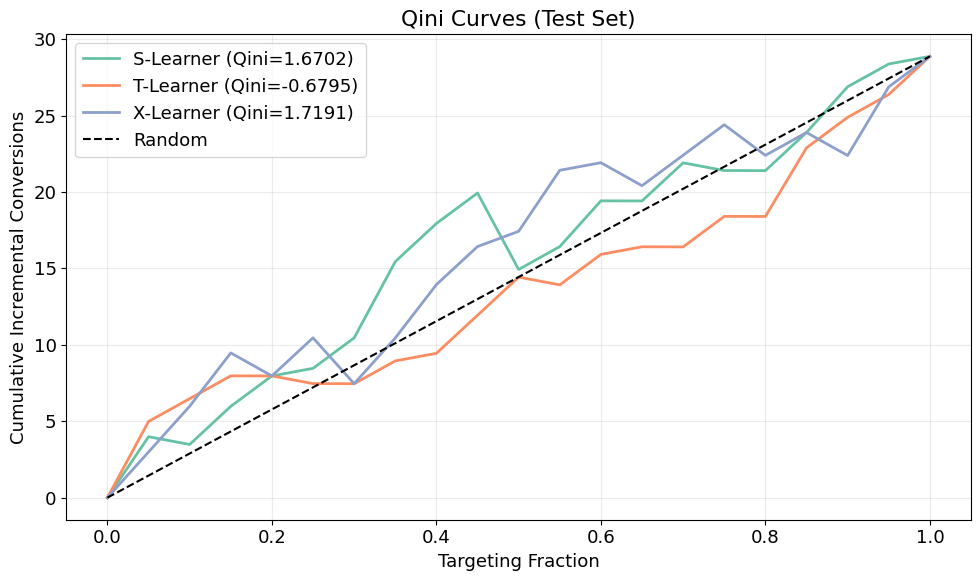

In [15]:
# ======================================================
# Section 6 (Cell 3/3): Plot Qini curves
# ======================================================
assert 'qini_s' in globals(), 'Missing qini_s'
assert 'qini_t' in globals(), 'Missing qini_t'
assert 'qini_x' in globals(), 'Missing qini_x'

plt.figure(figsize=(10, 6))
plt.plot(qini_s['qini_x'], qini_s['qini_y'], linewidth=2, label=f"S-Learner (Qini={qini_s['qini_coefficient']:.4f})")
plt.plot(qini_t['qini_x'], qini_t['qini_y'], linewidth=2, label=f"T-Learner (Qini={qini_t['qini_coefficient']:.4f})")
plt.plot(qini_x['qini_x'], qini_x['qini_y'], linewidth=2, label=f"X-Learner (Qini={qini_x['qini_coefficient']:.4f})")

# Random baseline
plt.plot(qini_s['qini_x'], qini_s['random_y'], linestyle='--', color='black', linewidth=1.5, label='Random')

plt.title('Qini Curves (Test Set)')
plt.xlabel('Targeting Fraction')
plt.ylabel('Cumulative Incremental Conversions')
plt.grid(alpha=0.25)
plt.legend()
plt.tight_layout()

out = figures_dir / 'fig_06_qini_curves.png'
plt.savefig(out, dpi=150, bbox_inches='tight')
print(f'.png saved: {out}')
plt.show()


In [16]:
# ======================================================
# Section 6 (Cell 3/3): Persist CATE vectors and Qini results
# ======================================================
# - Persist CATE vectors for Phase 3: data/processed/cate_vectors.npz
# - Persist Qini results (incl. curves) for degradation decision: data/processed/qini_results.json

import src.uplift
importlib.reload(src.uplift)
from src.uplift import fit_s_learner, fit_t_learner, fit_x_learner

# ------------------------
# 0) Preconditions
# ------------------------
assert 'config' in globals(), 'Missing config (loaded in Section 0)'
assert 'df' in globals(), 'Missing df (loaded in Section 0)'
assert 'X' in globals() and 'T' in globals() and 'Y' in globals(), 'Missing X/T/Y (Section 0)'
assert 'ps' in globals(), 'Missing ps (Section 0)'

assert 'qini_s' in globals() and 'qini_t' in globals() and 'qini_x' in globals(), 'Missing Qini dicts (Section 6)'
assert 'summary_df' in globals(), 'Missing summary_df (Section 6)'
assert 'best_learner' in globals() and 'best_qini' in globals(), 'Missing best_learner/best_qini (Section 6)'
assert 'n_estimators' in globals() and 'max_depth' in globals() and 'random_state' in globals(), 'Missing model hyperparameters'

cate_path = Path(config['paths']['cate_vectors'])
cate_path.parent.mkdir(parents=True, exist_ok=True)
qini_path = Path(config['paths']['qini_results'])
qini_path.parent.mkdir(parents=True, exist_ok=True)

# ------------------------
# 1) Persist Qini results (incl. curves)
# ------------------------
threshold = 0.01
best_learner_str = str(best_learner)
best_qini_val = float(best_qini)
decision = 'full' if best_qini_val >= threshold else 'lite'

T_test_series = T_test if isinstance(T_test, pd.Series) else pd.Series(T_test)
Y_test_series = Y_test if isinstance(Y_test, pd.Series) else pd.Series(Y_test)

qini_payload = {
    'meta': {
        'n_bins': int(n_bins),
        'n_test': int(len(T_test_series)),
        'treatment_rate_test': float(T_test_series.mean()),
        'threshold': float(threshold),
        'best_learner': best_learner_str,
        'best_qini_coefficient': best_qini_val,
        'decision': decision,
    },
    'S': qini_s,
    'T': qini_t,
    'X': qini_x,
}

with open(qini_path, 'w', encoding='utf-8') as f:
    json.dump(qini_payload, f, ensure_ascii=False, indent=2)
print(f'Persisted Qini results to: {qini_path}')

# ------------------------
# 2) Persist CATE vectors (FULL dataset, ~64K)
# ------------------------
# Important:
# - Qini evaluation must stay on test set.
# - But Phase 3 needs CATE for *all users* to do segmentation + ROI simulation.
# Therefore, after choosing/confirming the approach, we refit on full data and predict on full X.

ps_full = np.asarray(ps, dtype=float).reshape(-1)
assert len(ps_full) == len(df), 'ps length mismatch vs df'
assert np.isfinite(ps_full).all(), 'ps contains NaN/inf'

X_full = X.copy()
T_full = T.copy()
Y_full = Y.copy()

cate_s_full = fit_s_learner(
    X_full,
    T_full,
    Y_full,
    X_pred=X_full,
    n_estimators=int(n_estimators),
    max_depth=int(max_depth),
    random_state=int(random_state),
)
cate_t_full = fit_t_learner(
    X_full,
    T_full,
    Y_full,
    X_pred=X_full,
    n_estimators=int(n_estimators),
    max_depth=int(max_depth),
    random_state=int(random_state),
)
cate_x_full = fit_x_learner(
    X_full,
    T_full,
    Y_full,
    ps_full,
    X_pred=X_full,
    ps_pred=ps_full,
    n_estimators=int(n_estimators),
    max_depth=int(max_depth),
    random_state=int(random_state),
)

for name, vec in [('cate_s', cate_s_full), ('cate_t', cate_t_full), ('cate_x', cate_x_full)]:
    assert isinstance(vec, np.ndarray), f'{name} must be a numpy.ndarray'
    assert len(vec) == len(df), f'{name} length mismatch vs df'
    assert np.isfinite(vec).all(), f'{name} contains NaN/inf'

np.savez(
    cate_path,
    cate_s=np.asarray(cate_s_full, dtype=float),
    cate_t=np.asarray(cate_t_full, dtype=float),
    cate_x=np.asarray(cate_x_full, dtype=float),
)
print(f'Persisted CATE vectors to: {cate_path}')
print(f'cate vectors shapes: S={cate_s_full.shape}, T={cate_t_full.shape}, X={cate_x_full.shape}')


Persisted Qini results to: data\processed\qini_results.json
Persisted CATE vectors to: data\processed\cate_vectors.npz
cate vectors shapes: S=(64000,), T=(64000,), X=(64000,)


### Section 6 Summary

**Core Figures** (AUUC, Qini Coefficient)
| Learner | AUUC      | Random AUUC | Qini Coefficient |
|---------|----------|-------------|------------------|
| S       | 16.104638 | 14.434416   | 1.670222         |
| T       | 13.754919 | 14.434416   | -0.679497        |
| X       | 16.153513 | 14.434416   | 1.719097         |

**Insights**
- 对于前列接近 80% 的用户, X-Learner 的 Qini Curve 都高于随机线且整体优于S/T-Learner, 表明 X-Learner 做出了效果很好的 CATE 估计
- X-Learner 的 Qini 系数最高, 这符合理论预期: 在 T:C = 2:1 的不平衡场景下，X-Learner 通过交叉估计和 PS 加权，更有效地利用了多数组信息。
- 本次结果里 T-Learner 的 Qini 系数为负, 这并不一定意味着实现错误: 在转化率极低 (rare event) 的场景下, T-Learner 需要在 T=1 与 T=0 两个子样本上分别训练模型, 正例更稀少、方差更大，排序**噪声可能超过真实信号**，从而出现“劣于随机”的表现。这正是 X-Learner 的设计缓解的问题之一。

经过多种模型对比,验证了 X-Learner 在本数据集中的性能。后续的用户分桶, ROI 均建立在 X-Learner 的基础上进行

## Section 7: Mathematical Note — X-Learner Variance Superiority

### Theorem (Künzel et al. 2019)

**X-Learner 的方差优势**：在样本不平衡场景下（如 T:C = 2:1），X-Learner 的 CATE 估计方差满足：

$$
\text{Var}[\hat{\tau}_X(x)] \leq \min\left(\text{Var}[\hat{\tau}_T(x)], \text{Var}[\hat{\tau}_S(x)]\right)
$$

其中：
- $\hat{\tau}_X(x)$ 为 X-Learner 的 CATE 估计
- $\hat{\tau}_T(x) = \hat{\mu}_1(x) - \hat{\mu}_0(x)$ 为 T-Learner 的 CATE 估计
- $\hat{\tau}_S(x)$ 为 S-Learner 的 CATE 估计

**关键洞察**：当 $e(x) \to 1$ 时（Treatment 组占多数）：
- T-Learner 的 $\hat{\mu}_0(x)$ 方差爆炸（Control 样本稀少）
- X-Learner 的 $\hat{\tau}_X(x) \to \hat{\tau}_0(x)$（借用 Treatment 组模型 $\hat{\mu}_1$ 估计 Control 组效应）
- 方差由少数组的直接估计 → 多数组的交叉估计，噪声降低

### 方差分解（中文解释）

X-Learner 的方差优势源于"借力"机制：

**T-Learner 的方差困境**：
- 在 T:C = 2:1 的场景下，Control 组样本量仅为 Treatment 组的 1/2
- T-Learner 需要在 Control 组上独立训练 $\hat{\mu}_0(x)$，样本不足导致 $\text{Var}[\hat{\mu}_0(x)]$ 很大
- 最终 CATE 估计的方差：$\text{Var}[\hat{\tau}_T(x)] = \text{Var}[\hat{\mu}_1(x)] + \text{Var}[\hat{\mu}_0(x)]$（误差累积）

**X-Learner 的"交叉估计"降低方差**：
- 在 Treatment 组（多数组）：用 Control 的 $\hat{\mu}_0$ 模型估计反事实结果，得到伪残差 $D_1 = Y_1 - \hat{\mu}_0(x_1)$
- 在 Control 组（少数组）：用 Treatment 的 $\hat{\mu}_1$ 模型估计反事实结果，得到伪残差 $D_0 = \hat{\mu}_1(x_0) - Y_0$
- 关键：少数组（Control）的 CATE 估计 $\hat{\tau}_0(x)$ 借用了多数组（Treatment）的模型 $\hat{\mu}_1$，避免了在稀疏样本上直接拟合

**PS 加权的"信息融合"**：
- 最终 CATE = $(1 - e(x)) \cdot \hat{\tau}_1(x) + e(x) \cdot \hat{\tau}_0(x)$
- 当 $e(x)$ 高（Treatment 样本多）时，提高 $\hat{\tau}_0(x)$ 的权重（因为它借用了 Treatment 模型，更可靠）
- 当 $e(x)$ 低（Control 样本多）时，提高 $\hat{\tau}_1(x)$ 的权重（因为它借用了 Control 模型，更可靠）

**直觉总结**：X-Learner 通过"让信息量少的一侧借用信息量多的一侧的模型"，将方差从"少数组的直接估计"降低为"多数组的交叉估计"，从而在不平衡样本下获得更稳定的 CATE 排序信号。